# Task 7: Shopper sentiments

- The ShopperSentiments dataset, comprising over 250,000 customer reviews on
TeePublic, provides key insights for online fashion retail. Attributes include
reviewer_id, store_location, date, title, review, and review-label (rating 1 to 5).
- With unique features like geospatial coordinates and temporal data, it's a valuable
resource for sentiment analysis, geospatial patterns, temporal trends, and review
categorization.
- TeePublic's diverse fashion collection is the backdrop for understanding customer
sentiments and preferences.

# Shopper Sentiments dataset

## Description
This extensive dataset, comprised of over 250,000 customer reviews, offers a detailed exploration of customer experiences on TeePublic, an online platform renowned for its diverse collection of fashion items. The dataset spans crucial information, including `reviewer_id`, `store_location`, `latitude`, `longitude`, `date`, `month`, `year`, `title`, `review`, and the `review-label` indicating a rating on a scale of 1 to 5.

## Columns description
`reviewer_id`: A unique identifier for each reviewer, ensuring anonymity and privacy.
`store_location`: Geographic information specifying the location of the TeePublic fashion store.
`latitude`: The latitude coordinate of the store's location, providing precise geospatial data.
`longitude`: The longitude coordinate of the store's location, offering detailed geographic insights.
`date`: The specific date when the review was posted, enabling temporal analysis.
`month`: The month in which the review was posted, facilitating monthly trends exploration.
`year`: The year of the review, allowing for yearly analysis and trend identification.
`title`: The title associated with each review, capturing succinct sentiments or key points.
`review`: The textual content of the review, presenting detailed feedback from customers.
`review-label`: The reviewer's rating on a scale from 1 to 5, providing a quantitative measure of satisfaction.

## Store where data came from information:
TeePublic is a prominent online platform celebrated for its extensive collection of fashion items, including apparel, accessories, and more. This dataset, comprising reviews from the fashion store, serves as a valuable resource to understand customer sentiments and preferences within the dynamic landscape of online fashion retail.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk
from ydata_profiling import ProfileReport
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from warnings import filterwarnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

Retrieving data from Kaggle API, (using local machine)

In [2]:
# # Local PC data retrieving
# from kaggle.api.kaggle_api_extended import KaggleApi

# # Initialize the Kaggle API
# api = KaggleApi()
# api.authenticate()

# # Download the dataset
# api.dataset_download_files('nelgiriyewithana/shoppersentiments', path='D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw', unzip=True)

# Read the data as a pandas dataframe
df = pd.read_csv("C:/Ankit/Dataset/CognoRise_Infotech/raw/TeePublic_review.csv", encoding='latin1')
df.head()

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,0.0,US,37.090240,-95.712891,2023,6,2015 00:00:00,Great help with lost order,I had an order that was lost in transit. When ...,5
1,1.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,2.0,US,37.090240,-95.712891,2023,6,2017 00:00:00,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5
3,3.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Good Stuff,Looked for an obscure phrase on a shirt. Teepu...,5
4,4.0,CA,56.130366,-106.346771,2023,6,2023 00:00:00,My order arrived in a good timelyï¿½ï¿½ï¿½,My order arrived in a good timely fashion & th...,4


# Data cleaning and overview of the data

ProfileReport of the data

From this firts ProfileReport it can be concluded the following:
- The dataset is mid-high dimensionality with more than $278.000$ rows and 10 predictor variables.
- The data has nulls, specifically in the `review` column, with more than $11 \%$ nulls of total data.
- `reviewer_id` is an useless column, it has to be deleted.
- Sells reviews increase in month 12, apparently December.
- Most of the reviews are from US products.
- The `review` and `title` variables have many stopwords and they are the most common as excpected, it has to be made a treatment of this for sentiment analysis.
- Most reviews are good.
- The `review` and `title` variables are the ones with null data.

Analysis of unique values

By this analysis it can be concluded that the `year` column has not any relationship with the date-related columns, also by the correlation heatmap given by the ProfileReport, these variables have almost nothing in common and it's weird that in the dataset description it is not mentioned what exactly this column is. Is not the year the review was made because are years more than the present one, (2024), so I decide to eliminate this column based on its unclear proccedence.

In [5]:
print(f'The types of data in the dataset are: \n{df.dtypes}')

The types of data in the dataset are: 
reviewer_id       float64
store_location     object
latitude          float64
longitude         float64
date                int64
month               int64
year               object
title              object
review             object
review-label        int64
dtype: object


In [6]:
for i in df.columns:
    if i not in ['title', 'review', 'latitude', 'longitude']:
        print(f'Unique values for column {i} are: {df[i].unique()}')

Unique values for column reviewer_id are: [0.00000e+00 1.00000e+00 2.00000e+00 ... 2.78097e+05 2.78098e+05
         nan]
Unique values for column store_location are: ['US' 'CA' 'GB' 'AU' 'NZ' 'DE' 'BG' 'NL' 'SE' 'MY' 'NO' 'MA' 'IN' 'IT'
 'JP' 'PT' 'BE' 'FR' 'CH' 'HU' 'SG' 'TH' 'HK' 'SI' 'AT' 'CZ' 'UA' 'ID'
 'RO' 'ES' 'MX' 'IL' 'RS' 'PK' 'GI' 'SK' 'FI' 'LT' 'IE' 'PR' 'GU' 'LU'
 'JO' 'AE' 'IS' 'PL' 'HR' 'EC' 'BR' 'TR' 'DK' 'MT' 'BS' 'CY' 'CO' 'JM'
 'TW' 'NC' 'DO' 'CK' 'KR' 'MR' 'HT' 'VN' 'SR' 'EE' 'RU' 'PA' 'PH' 'CR'
 'IM' 'KH' 'EG' 'DZ' 'VE' 'NI' 'BH' 'CL' 'BM' 'TC' 'LK' 'SA' 'GR' 'BO'
 'AR' 'GT' 'TN' 'LV' 'CN' 'GD' 'ZA' 'QA' 'UY' 'AF' 'KW' 'BD' 'KZ' 'KY'
 'SV' 'KE' 'MD' 'PE' 'AX' 'GY' 'TT' 'HN' 'GP' 'PY' 'SY' 'VI' 'WS' 'BB'
 'GE' 'IQ' 'LB' 'TZ' 'NG' 'OM' 'SX' 'LI' 'LC' 'MN' 'GG' 'MK' 'BZ' 'JE'
 'MM' 'CM' 'MV' 'UZ' 'BA' 'PF' 'GF' 'GH' 'AW' 'MZ' 'CI' 'MW' 'CW' 'MO'
 'UG']
Unique values for column date are: [2023 2022 2021 2020 2019 2018]
Unique values for column month are: [ 6  3  5  4  

Eliminating unimportant columns

In [7]:
df.drop(['year', 'reviewer_id'], axis=1, inplace=True)

Information about nulls, infinite values and duplicates on the data

In [8]:
nulls = df.isnull()
duplicated_rows = df.duplicated()

print(f'Total of null data: {df.isnull().sum().sum()}')
print(f'Total of duplicated data: {duplicated_rows.sum()}')
print(f'Percentage of total duplicated data: {duplicated_rows.mean() * 100:.1f}%')
print(f'Percentage of total null data: {df.isnull().sum().sum() / df.shape[0] * 100:.1f}%')

Total of null data: 30515
Total of duplicated data: 1536
Percentage of total duplicated data: 0.6%
Percentage of total null data: 11.0%


In [9]:
# Dropping duplicated rows
df = df.copy()[~duplicated_rows]

Renaming columns so it has a clear pattern

In [10]:
new_columns = [column.replace('-', '_') for column in df.columns]
df.columns = new_columns
print(f'New columns names: {df.columns}')

New columns names: Index(['store_location', 'latitude', 'longitude', 'date', 'month', 'title',
       'review', 'review_label'],
      dtype='object')


From the ProfileReport it can be concluded that the `review` and `title` columns are the ones with null data, so these columns without its nulls will be selected to make the Machine Learning model for sentiment analysis, but the EDA, (Exploratory Data Analysis), will be made with the entire dataset containing nulls since it will be more focused on the other variables and how to use them to improve the sentiment analysis model.

In [11]:
# Dividing the dataset into two parts: one with null values and the other without null values
df_eda = df.copy()
df_sentiment = df[~df.isnull().any(axis=1)]

# EDA, (Exploratory Data Analysis)

In [13]:
df.head(3)

,store_location,latitude,longitude,date,month,title,review,review_label
0,US,37.09024,-95.712891,2023,6,Great help with lost order,I had an order that was lost in transit. When ...,5
1,US,37.09024,-95.712891,2023,6,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,US,37.09024,-95.712891,2023,6,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5


From the following graph it can also be concluded that there exists an imbalance in the `review_label` column.

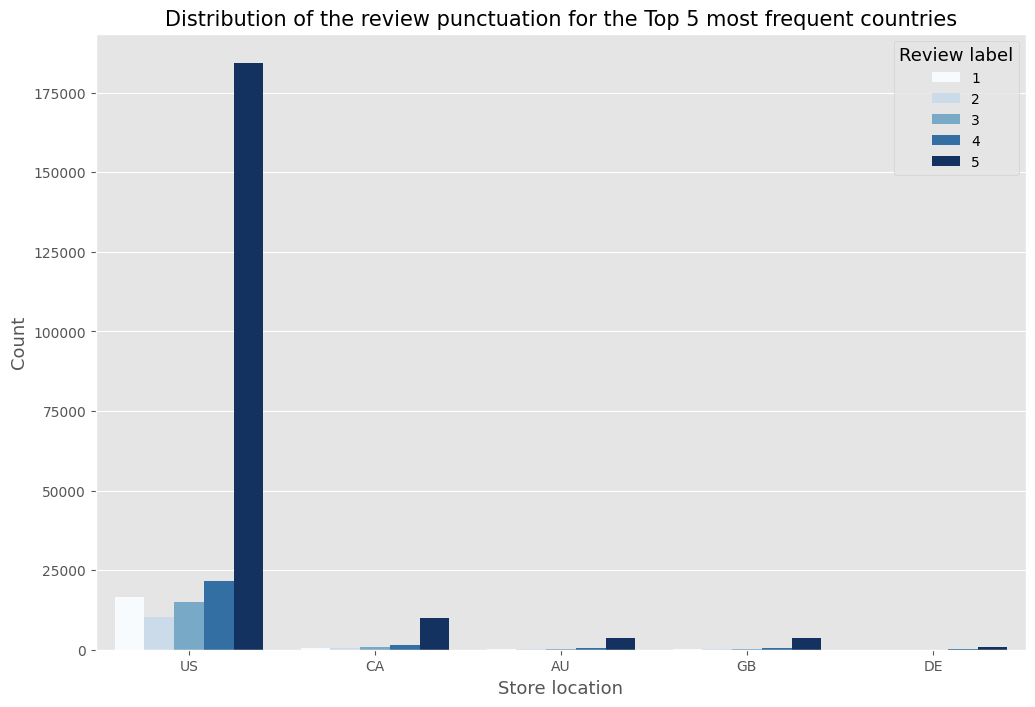

In [14]:
top_countries = df_eda['store_location'].value_counts().head(5).index # Top 5 countries with more reviews
df_top_countries = df_eda[df_eda['store_location'].isin(top_countries)] # Filtering the data with the top 5 countries

# Sorting the data
df_top_countries = df_top_countries.sort_values('store_location')

plt.figure(figsize=(12, 8))
# Plotting the distribution of the review-label for the top 5 countries more repeated
ax = sns.countplot(data=df_top_countries, x='store_location',
                   hue='review_label', order = df_top_countries['store_location'].value_counts().index, palette='Blues')

plt.legend(title='Review label', title_fontsize='13', loc='upper right')
plt.title('Distribution of the review punctuation for the Top 5 most frequent countries', size=15)
plt.xlabel('Store location', size=13)
plt.ylabel('Count', size=13)

plt.show()

In [15]:
# Aggregate data to get total reviews per store location
df_agg = df_eda.groupby(['store_location', 'latitude', 'longitude']).size().reset_index(name='review_count')

# Apply a logarithmic transformation to 'review_count'
df_agg['log_review_count'] = round(np.log(df_agg['review_count']), 1)

# Round the log_review_count to one decimal
df_agg['log_review_count_rounded'] = df_agg['log_review_count'].round(1)

# Create bubble map
fig = px.scatter_geo(df_agg,
                     lat='latitude',
                     lon='longitude',
                     color='log_review_count_rounded',
                     size='log_review_count',
                     hover_name='store_location',
                     hover_data={'log_review_count_rounded': True, 'review_count': True},
                     projection='natural earth',
                     title='Number of reviews per store location (Log scale)',
                     color_continuous_scale=px.colors.sequential.Blugrn
)

# Add colorbar
fig.update_layout(coloraxis_colorbar=dict(title='Log of Review Count', tickformat='.1f'))

# Improve color scale
fig.update_traces(marker=dict(colorbar=dict(tickvals=[0, 2, 4, 6, 8], ticktext=['0', '100', '10000', '1000000', '100000000'])))

# Add title and labels
fig.update_layout(title_text="Number of reviews per store location (Log scale)",
                  xaxis_title="Longitude",
                  yaxis_title="Latitude")

# Add annotations
fig.add_annotation(
            x=0.5,
            y=-0.15,
            xref="paper",
            yref="paper",
            text="Size of bubbles represents the log of review count.",
            showarrow=False,
            font=dict(
                size=15,
                color="black"
            )
        )
fig.add_annotation(
            x=0.5,
            y=-0.19,
            xref="paper",
            yref="paper",
            text="This is made to better represent the data in the map.",
            showarrow=False,
            font=dict(
                size=15,
                color="black"
            )
        )

# Adjust the size and margins of the map
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=10
    )
)

fig.show()

From the following histograms and boxplots of both `date` (year) and `month` columns, we can conclude the following:
- The initial months of the year have the least amout of reviews of products.
- The last months of the year are the most relevant regarding reviews of products, this could be by a tendency of more items bought due to festivities.
- 2022 was the most important year for the company in termns of count of reviews of products. 

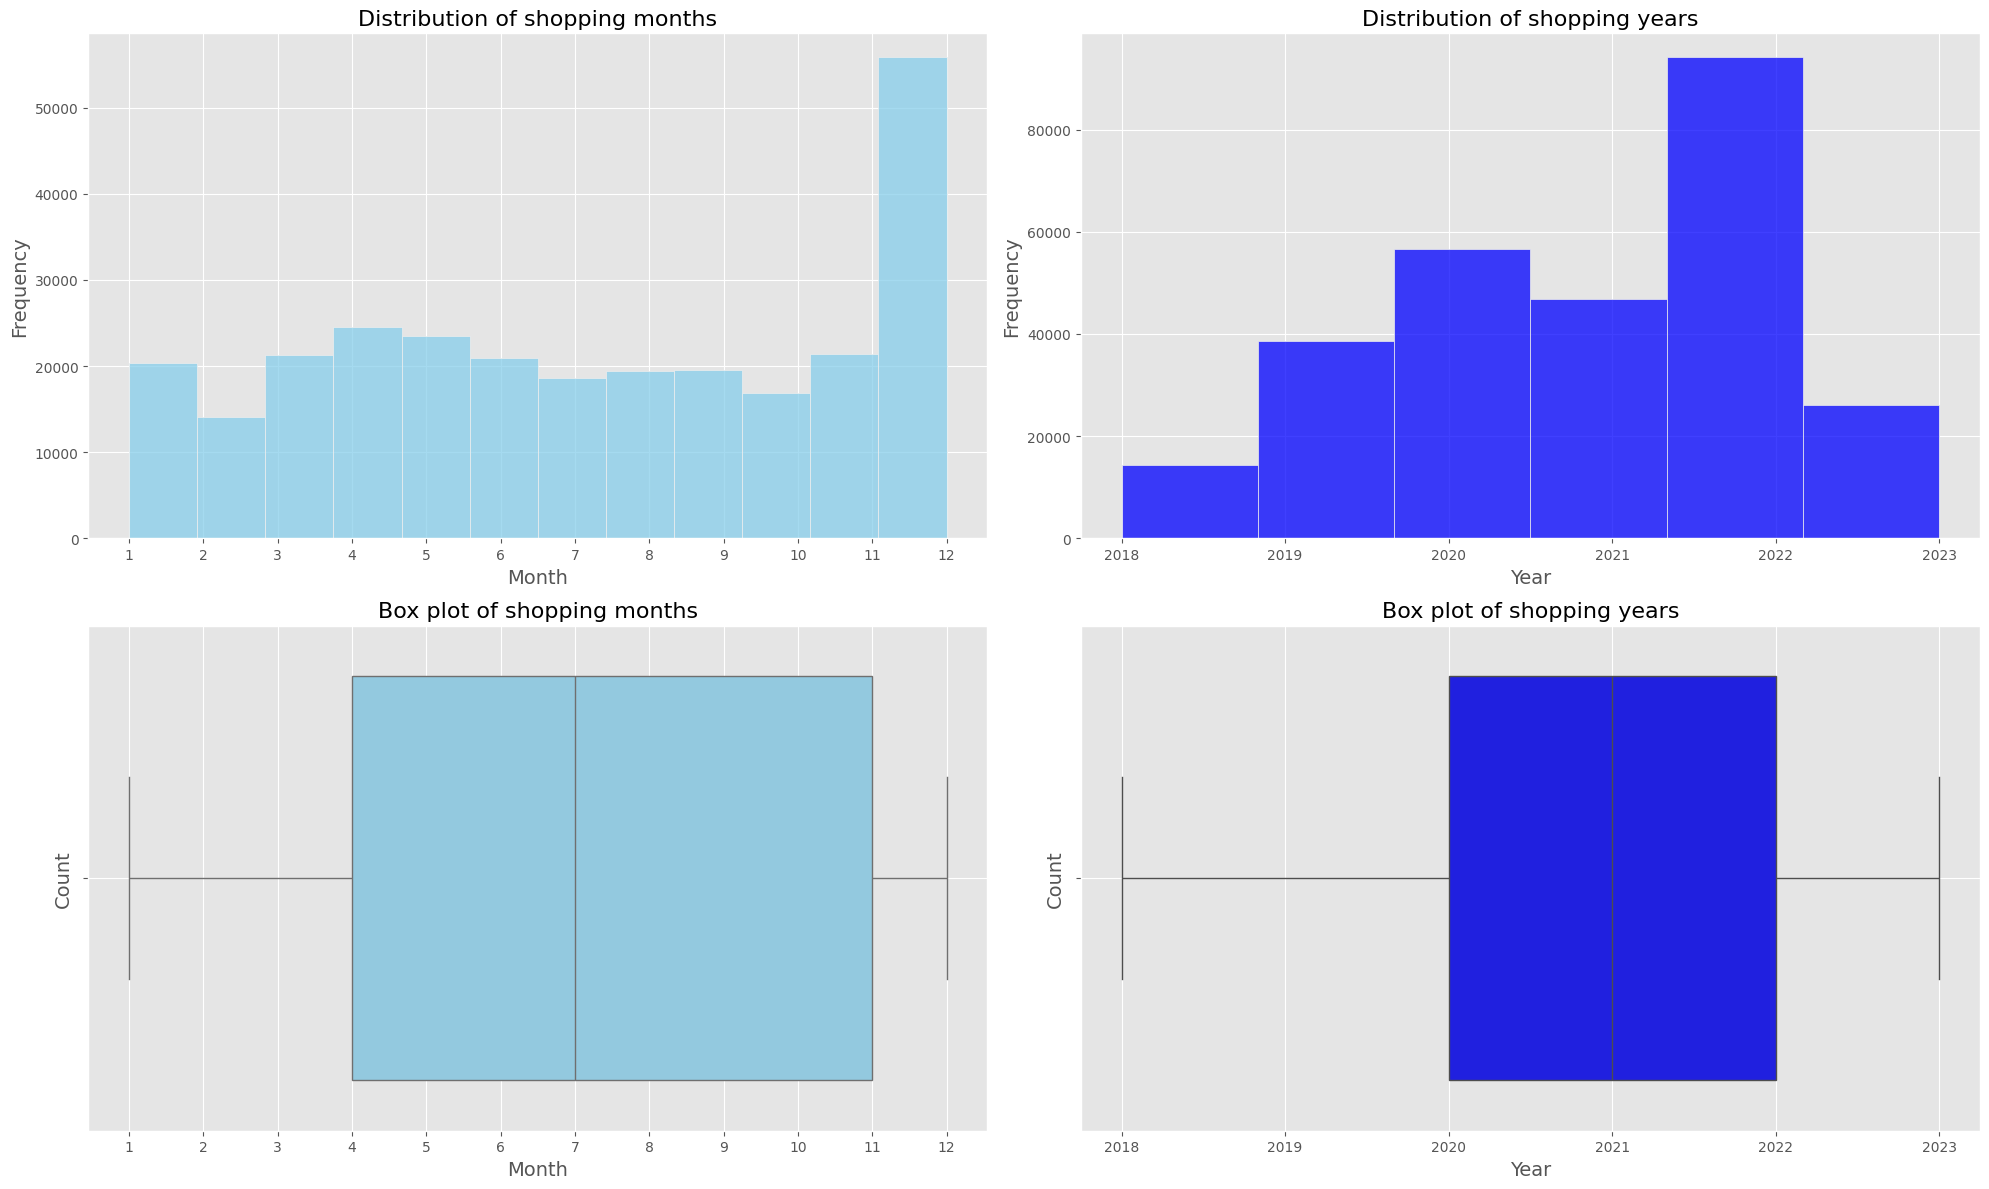

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Histogram of the distribution of the review punctuation by month
sns.histplot(df_eda['month'], bins=12, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Distribution of shopping months', fontsize=16)
axs[0, 0].set_xlabel('Month', fontsize=14)
axs[0, 0].set_ylabel('Frequency', fontsize=14)
axs[0, 0].set_xticks(range(1, 13))
axs[0, 0].grid(True)

# Histogram of the distribution of the review punctuation by year
sns.histplot(df_eda['date'], bins=len(df_eda['date'].unique()), ax=axs[0, 1], color='blue')
axs[0, 1].set_title('Distribution of shopping years', fontsize=16)
axs[0, 1].set_xlabel('Year', fontsize=14)
axs[0, 1].set_ylabel('Frequency', fontsize=14)
axs[0, 1].grid(True)

# Box plot of the review punctuation by month
sns.boxplot(x=df_eda['month'], ax=axs[1, 0], color='skyblue')
axs[1, 0].set_title('Box plot of shopping months', fontsize=16)
axs[1, 0].set_xlabel('Month', fontsize=14)
axs[1, 0].set_ylabel('Count', fontsize=14)
axs[1, 0].set_xticks(range(1, 13))
axs[1, 0].grid(True)

# Box plot of the review punctuation by year
sns.boxplot(x=df_eda['date'], ax=axs[1, 1], color='blue')
axs[1, 1].set_title('Box plot of shopping years', fontsize=16)
axs[1, 1].set_xlabel('Year', fontsize=14)
axs[1, 1].set_ylabel('Count', fontsize=14)
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
print(f'Description of the dataset: \n{df_eda.describe()}')

Description of the dataset: 
            latitude      longitude           date          month  \
count  276564.000000  276564.000000  276564.000000  276564.000000   
mean       37.190765     -88.152294    2020.888865       7.197882   
std        10.236827      37.099432       1.390961       3.676814   
min       -40.900557    -172.104629    2018.000000       1.000000   
25%        37.090240     -95.712891    2020.000000       4.000000   
50%        37.090240     -95.712891    2021.000000       7.000000   
75%        37.090240     -95.712891    2022.000000      11.000000   
max        64.963051     174.885971    2023.000000      12.000000   

        review_label  
count  276564.000000  
mean        4.407269  
std         1.179915  
min         1.000000  
25%         4.000000  
50%         5.000000  
75%         5.000000  
max         5.000000  


# Classification model

The column `review_label` is imbalanced, we can see this looking at the quantity of rows from every label of the review

I choose to make an undersampling of the data to just have 10716 rows of data for every label so each class has the same amount of data. In total, the data to train the model will be 53580 rows.

In [18]:
# Undersampling technique to the df_sentiment dataset
n_samples = 10716
df_sentiment = df_sentiment.groupby('review_label').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)

df_sentiment['review_label'] = df_sentiment['review_label'].map({1:0, 2:1, 3:2, 4:3, 5:4}) # Mapping the labels to 0-4, some ML models need this format

In [19]:
# Converting the 'review_label' column to integer type
df_sentiment['review_label'] = df_sentiment['review_label'].astype(int)

# Dataset into features (X) and target (y)
X = df_sentiment.drop('review_label', axis=1)
y = df_sentiment['review_label']

In [20]:
# Downloading stopwords and punctuation from NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Defining a function to tokenize text and remove stopwords
stop_words = set(stopwords.words('english'))

# Preprocess function to remove stopwords and punctuation
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if not word in stop_words]
    return ' '.join(tokens)

# Applying text preprocessing to the 'review' and 'title' columns
X['review'] = X['review'].apply(preprocess_text)
X['title'] = X['title'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y) # stratify to keep the same distribution of the target variable

Since this is a multivariative classification task, where the target are 5 classes, my preference is to utilize an Ensemble model, which essentially combines multiple machine learning models, (in this case, three), for classification tasks. The goal of this approach is to create a more robust model that leverages the strengths of each individual model.

In [22]:
# Preprocessing steps
preprocess = ColumnTransformer(
    transformers=[
        ('text_review', TfidfVectorizer(), 'review'),    # vectorizing the 'review' column
        ('text_title', TfidfVectorizer(), 'title'),      # vectorizing the 'title' column
        ('text_location', TfidfVectorizer(), 'store_location'),  # vectorizing the 'store_location' column
        ('scale_date', MinMaxScaler(), ['date']),  # MinMaxScaler for 'date'
        ('scale_month', MinMaxScaler(), ['month']),  # MinMaxScaler for 'month'
        ('scale_longitude', MinMaxScaler(), ['longitude']),  # MinMaxScaler for 'longitude'
        ('scale_latitude', MinMaxScaler(), ['latitude']),  # MinMaxScaler for 'latitude'
    ]
)

# Models to use and its parameters
model1 = RandomForestClassifier(n_estimators=300, max_depth=60, min_samples_split=2, min_samples_leaf=2, random_state=42)
model2 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, subsample=0.5, max_depth=6, random_state=42)
model3 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=250, learning_rate=0.1, max_depth=6, gamma=0.5, subsample=0.6, random_state=42)

# Creating the pipeline
pipeline1 = Pipeline([
    ('preprocess', preprocess), # Preprocessing
    ('classifier', model1)       # Model
])

pipeline2 = Pipeline([
    ('preprocess', preprocess),
    ('classifier', model2)
])

pipeline3 = Pipeline([
    ('preprocess', preprocess),
    ('classifier', model3)
])

# Fit of each pipeline
pipeline1.fit(X_train, y_train)
pipeline2.fit(X_train, y_train)
pipeline3.fit(X_train, y_train)

# Creating the ensemble model with the fitted models
ensemble_model = VotingClassifier(estimators=[
    ('rf', pipeline1),
    ('gb', pipeline2),
    ('xgb', pipeline3)
], voting='soft')

# Fitting the ensemble model
ensemble_model.fit(X_train, y_train)

predictions = ensemble_model.predict(X_test) # Predictions

In [23]:
from joblib import dump

# Saving the model
dump(ensemble_model, 'C:/Ankit/Dataset/CognoRise_Infotech/models/ensemble_model-sentiment.joblib') 

['D:/Estiven/Datos/Proyectos/CognoRise_Infotech/models/ensemble_model-sentiment.joblib']

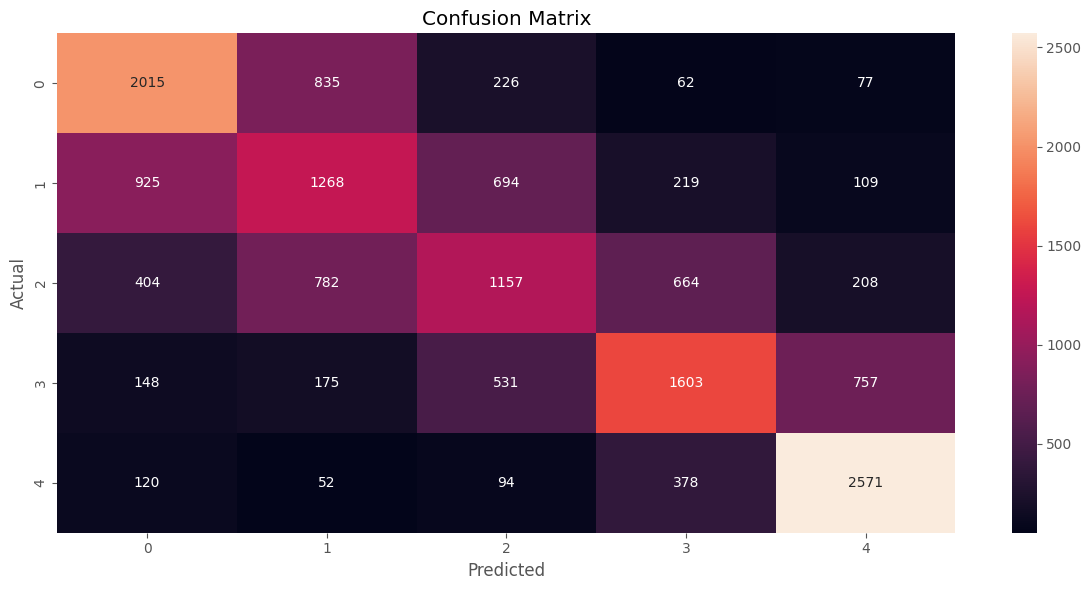

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))

# Plotting Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [25]:
# Predictions on training set
train_predictions = ensemble_model.predict(X_train)

# Classification report for training set
train_report = classification_report(y_train, train_predictions)
print(f"Training Classification Report:\n{train_report}\n")

# Classification report for testing set
test_report = classification_report(y_test, predictions)
print(f"Testing Classification Report:\n{test_report}")

Training Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      7501
           1       0.76      0.73      0.74      7501
           2       0.78      0.69      0.73      7501
           3       0.78      0.71      0.74      7502
           4       0.79      0.90      0.85      7501

    accuracy                           0.77     37506
   macro avg       0.77      0.77      0.77     37506
weighted avg       0.77      0.77      0.77     37506


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.63      0.59      3215
           1       0.41      0.39      0.40      3215
           2       0.43      0.36      0.39      3215
           3       0.55      0.50      0.52      3214
           4       0.69      0.80      0.74      3215

    accuracy                           0.54     16074
   macro avg       0.53      0.54      0.53     16074
weighted avg 

The model performed fairly well on the training data, with an overall accuracy of 75%. The precision, recall, and F1-score were also around 75% for each class, indicating a balanced performance across all classes. The model performed best on class 4, with a precision of 77% and recall of 89%.

However, the model's performance dropped on the testing data, with an overall accuracy of 53%. The precision, recall, and F1-score were around 52% for each class. The model still performed best on class 4, with a precision of 67% and recall of 79%.

The drop in performance from training to testing suggests that the model may be overfitting the training data.

Given the time, it was not possible to further optimize this model. However, there are several strategies that could potentially improve its performance:

1. **Regularization**: This technique adds a penalty term to the loss function to discourage overfitting. Common methods include L1 and L2 regularization.

2. **Cross-validation**: This technique involves splitting the training data into several subsets and training the model on each subset. This can help to ensure that the model generalizes well to unseen data.

4. **Hyperparameter tuning**: This involves adjusting the parameters of the model to find the optimal values. This can be done manually, or using techniques like grid search or random search.

5. **Feature engineering**: This involves creating new features from the existing data, which can help to improve the model's performance.

# Sentiment analysis using textblob Python library

TextBlob is a Python library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

In the context of sentiment analysis, TextBlob uses a pre-trained analyzer to assign polarity scores to the input text. The polarity score is a float within the range [-1.0, 1.0].

In this code, I will use TextBlob to perform sentiment analysis on the `review` column of the DataFrame. Here's a step-by-step breakdown of the cell:

1. I define a function `get_sentiment` that takes a text input and returns the polarity score of the text using TextBlob's sentiment analysis capability.

2. I apply a preprocessing function to the `review` and `title` columns. This is the same function used before to process the data in the X variable to train the classification ensemble model.

3. I apply the `get_sentiment` function to the `title` column, creating a new column `sentiment` that contains the sentiment score of each review. This score represents the overall sentiment of the review, with positive scores indicating positive sentiment, negative scores indicating negative sentiment, and scores close to zero indicating neutral sentiment.

In [26]:
from textblob import TextBlob

def get_sentiment(text):
    """
    Function to apply sentiment analysis to a text.
    Args:
    text : str : The text to analyze.
    Returns:
    float : The sentiment polarity of the text.
    """
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

# Preprocess text data
df.dropna(inplace=True)
df['review'].apply(preprocess_text)
df['title'].apply(preprocess_text)

# Apply sentiment analysis on the 'review' column
df['sentiment'] = df['review'].apply(get_sentiment)

From the sentiment analysis and the graphs provided, it can be concluded the following:
- There are more positive reviews than the sum of neutral and negative, which is great.
- The tendency of the sentiment by label tend to increase as seen in the boxplots. The higher the label, the higher the mean of the boxplot, meaning a more positive sentiment.

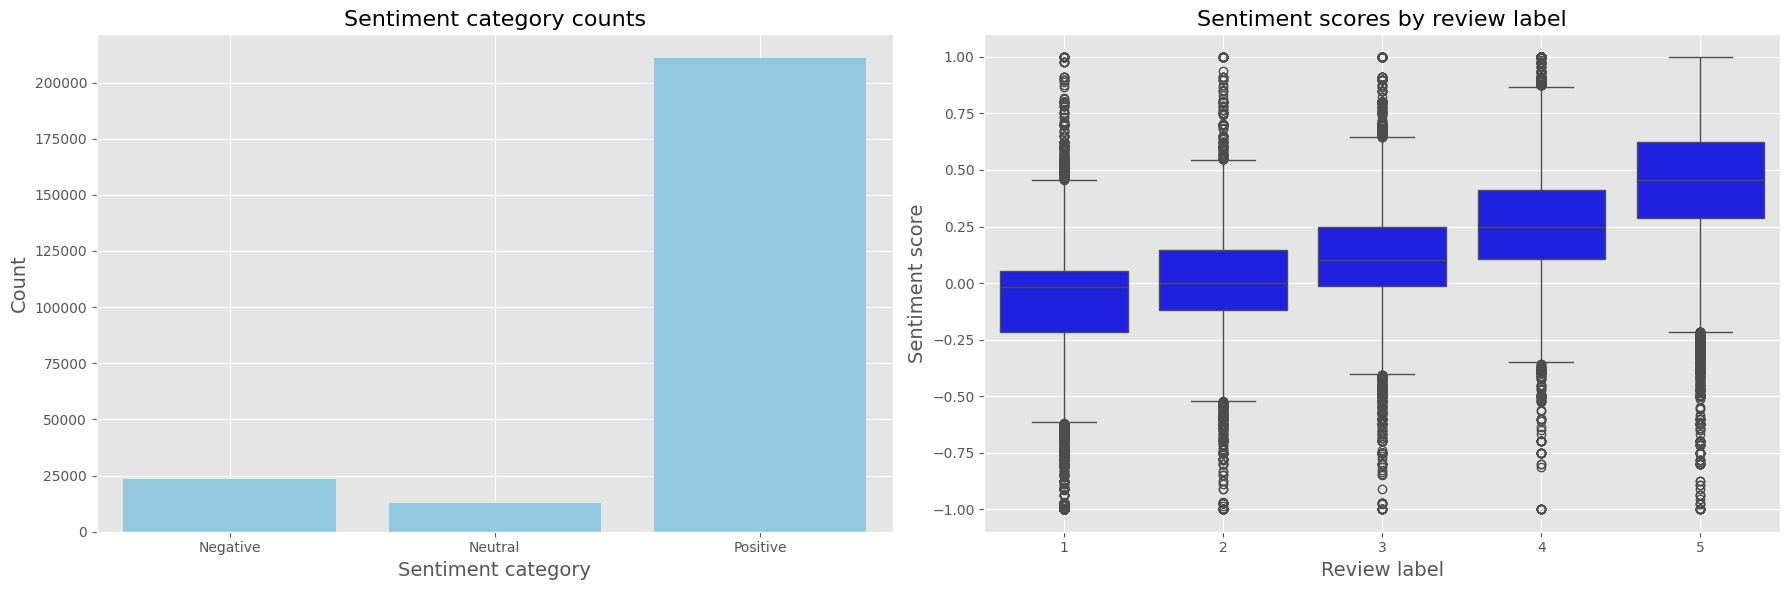

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Function to categorize sentiment
def get_sentiment_category(score):
    if score < 0:
        return 'Negative'
    elif score > 0:
        return 'Positive'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment'].apply(get_sentiment_category)

# Subplot for sentiment category counts
sns.countplot(x='sentiment_category', data=df, order=['Negative', 'Neutral', 'Positive'], ax=axs[0], color='skyblue')
axs[0].set_title('Sentiment category counts', fontsize=16)
axs[0].set_xlabel('Sentiment category', fontsize=14)
axs[0].set_ylabel('Count', fontsize=14)
axs[0].grid(True)

# Subplot for sentiment scores by review label
sns.boxplot(x='review_label', y='sentiment', data=df, ax=axs[1], color='blue')
axs[1].set_title('Sentiment scores by review label', fontsize=16)
axs[1].set_xlabel('Review label', fontsize=14)
axs[1].set_ylabel('Sentiment score', fontsize=14)
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [28]:
print("Count of each sentiment category:")
print(df['sentiment_category'].value_counts())

print("\nMean sentiment score for each review label:")
print(df.groupby('review_label')['sentiment'].mean())

Count of each sentiment category:
sentiment_category
Positive    210916
Negative     23568
Neutral      12777
Name: count, dtype: int64

Mean sentiment score for each review label:
review_label
1   -0.083990
2    0.007008
3    0.110601
4    0.268407
5    0.457667
Name: sentiment, dtype: float64
